In [2]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.auto import tqdm, trange

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

In [264]:
# pot = gp.NFWPotential.from_M200_c(1e12*u.Msun, c=15, 
#                                   units=galactic)
# pot = gp.MilkyWayPotential()

pot = gp.LeeSutoTriaxialNFWPotential(v_c=229*u.km/u.s, r_s=15.5*u.kpc, 
                                     a=1, b=0.9, c=0.8, units=galactic)
# pot = gp.LeeSutoTriaxialNFWPotential(v_c=229*u.km/u.s, r_s=15.5*u.kpc, 
#                                      units=galactic)

In [265]:
w0_1 = gd.PhaseSpacePosition([10., 0, 2] * u.kpc,
                             [0, 0, 150] * u.km/u.s)
w0_2 = gd.PhaseSpacePosition(w0_1.xyz + 1 * u.pc,
                             w0_1.v_xyz + 1e-1 * u.km/u.s)
dpos_0 = (w0_1.pos - w0_2.pos).norm()
dvel_0 = (w0_1.vel - w0_2.vel).norm()

w0s = gd.combine((w0_1, w0_2))

In [266]:
# orbits = pot.integrate_orbit(w0s, dt=0.1, t1=0, t2=8*u.Gyr, 
orbits = pot.integrate_orbit(w0s, dt=1., t1=0, t2=100*u.Gyr, 
                             Integrator=gi.DOPRI853Integrator)
P = np.mean(orbits.estimate_period())
P_idx = np.abs(orbits.t - P).argmin()

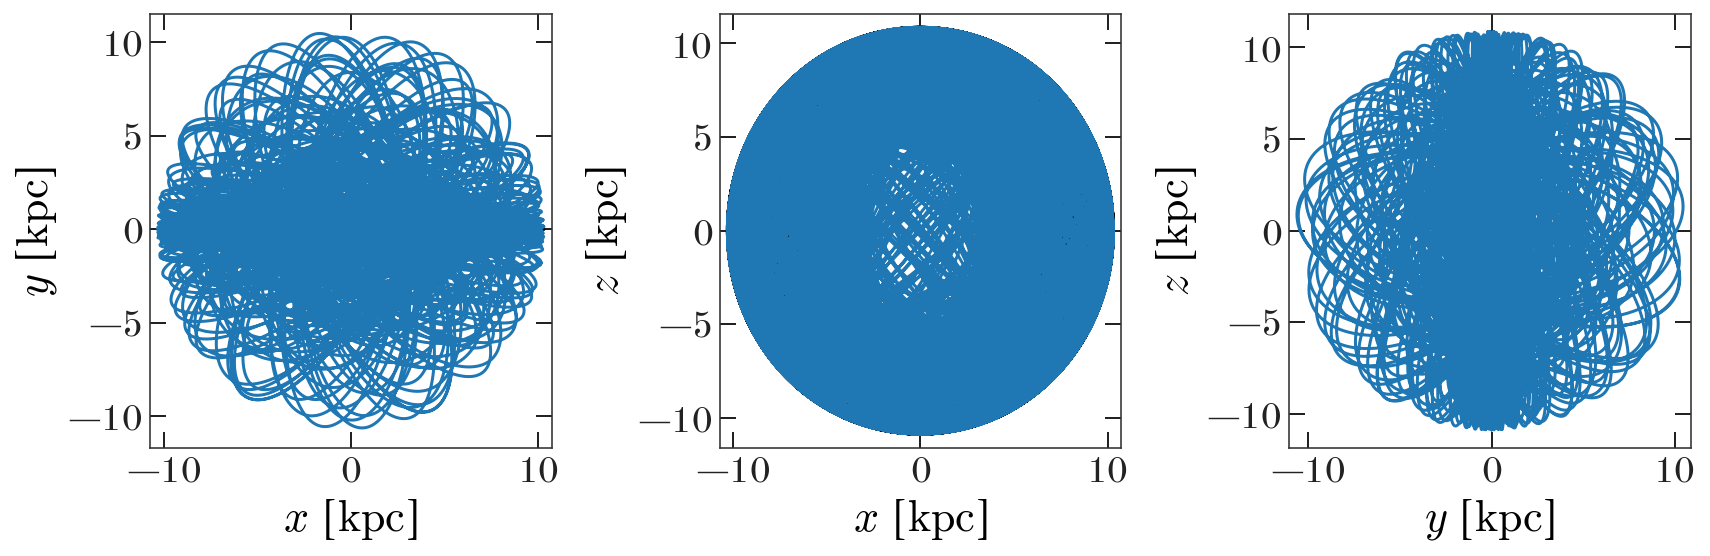

In [267]:
_ = orbits.plot()

In [268]:
dpos = (orbits[:, 0].pos - orbits[:, 1].pos).norm()
dvel = (orbits[:, 0].vel - orbits[:, 1].vel).norm()

In [269]:
# pos_norm = 1.*u.kpc
# vel_norm = 1.*u.km/u.s

# pos_norm = dpos_0
# vel_norm = dvel_0

pos_norm = dpos[P_idx]
vel_norm = dvel[P_idx]

dpos_norm = (dpos / pos_norm).decompose()
dvel_norm = (dvel / vel_norm).decompose()

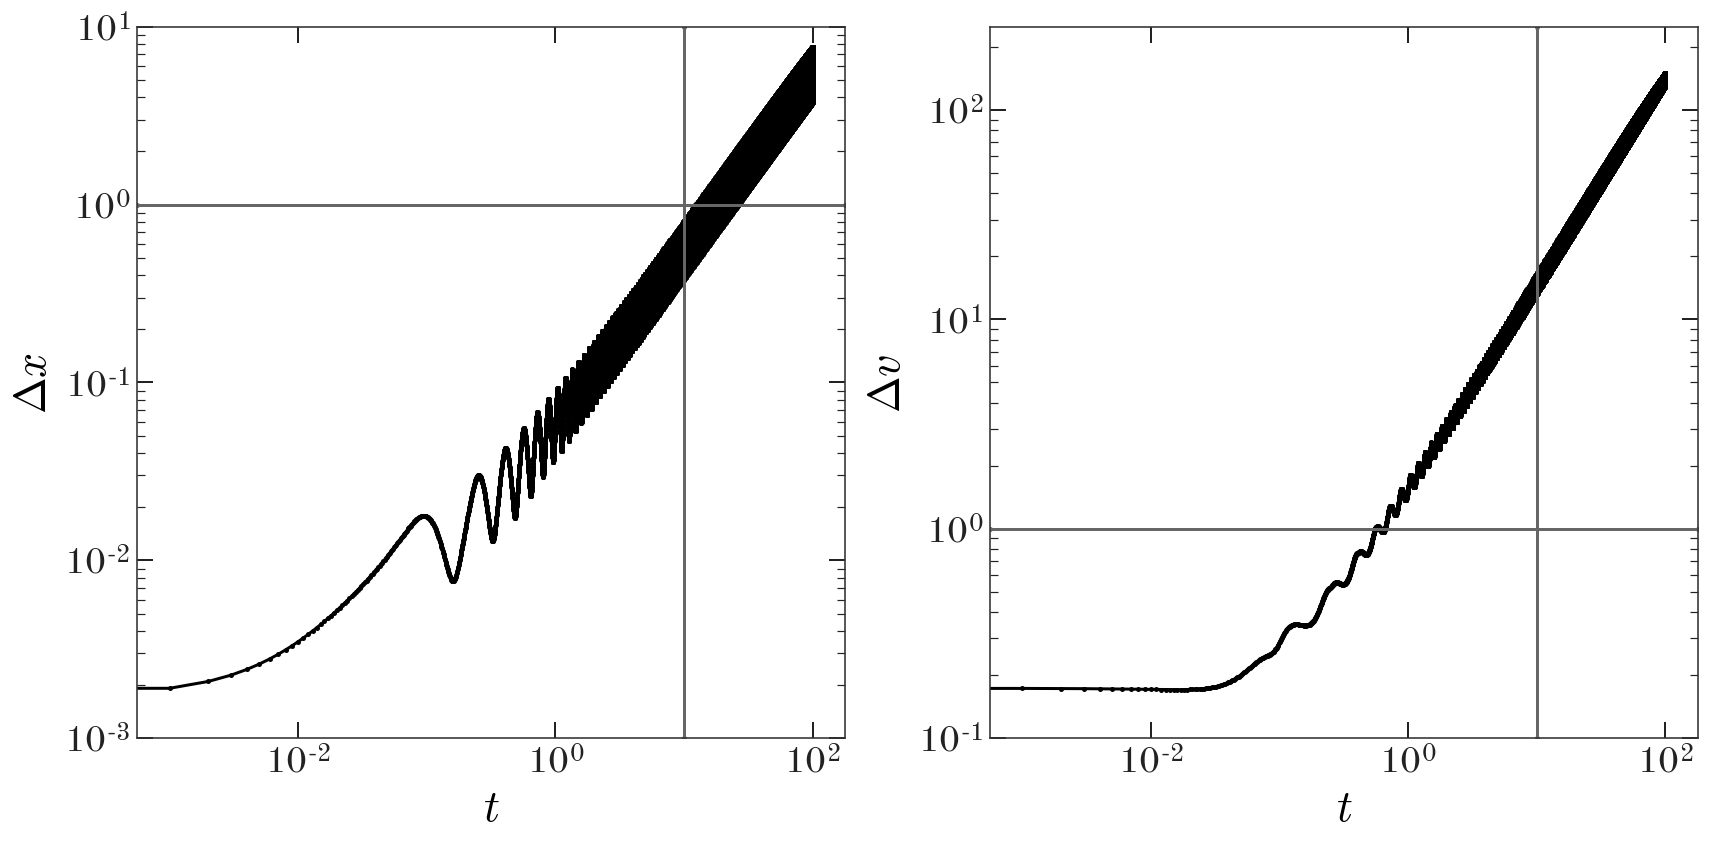

In [263]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         sharex=True)

ax = axes[0]
ax.plot(orbits.t.to_value(u.Gyr), dpos.to_value(u.kpc))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\Delta x$')
ax.set_yscale('log')

ax = axes[1]
ax.plot(orbits.t.to_value(u.Gyr), dvel.to_value(u.km/u.s))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\Delta v$')
# ax.set_xlim(1, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')

axes[0].set_ylim(1e-3, 10)
axes[1].set_ylim(1e-1, 250)

for ax in axes:
    ax.axvline(10.)
    ax.axhline(1.)

fig.tight_layout()

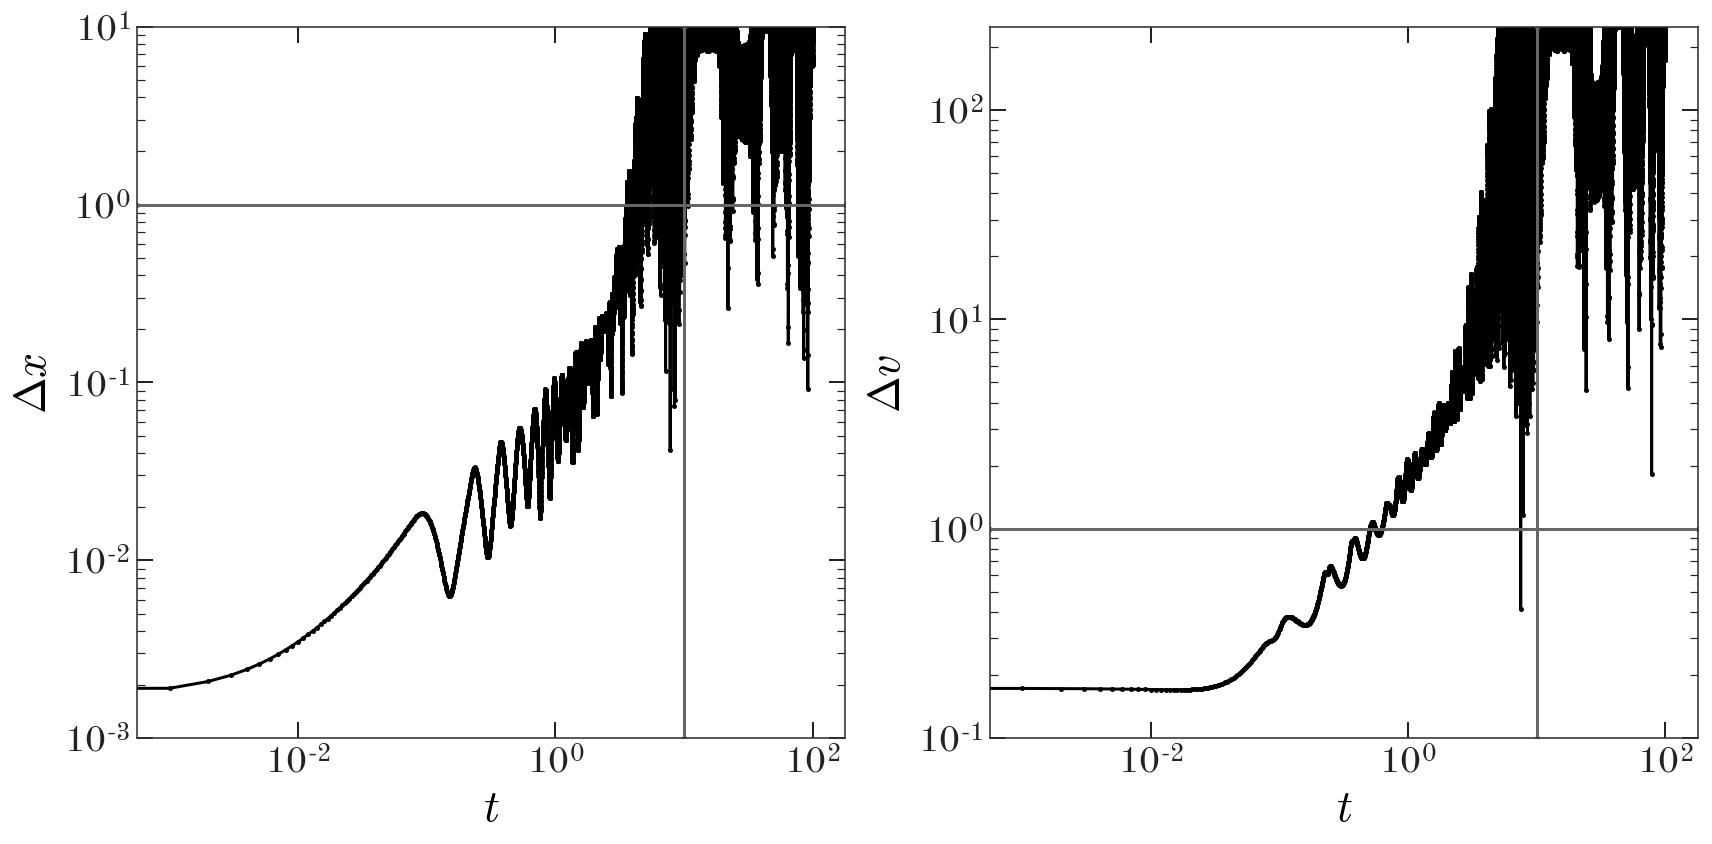

In [270]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         sharex=True)

ax = axes[0]
ax.plot(orbits.t.to_value(u.Gyr), dpos.to_value(u.kpc))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\Delta x$')
ax.set_yscale('log')

ax = axes[1]
ax.plot(orbits.t.to_value(u.Gyr), dvel.to_value(u.km/u.s))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\Delta v$')
# ax.set_xlim(1, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')

axes[0].set_ylim(1e-3, 10)
axes[1].set_ylim(1e-1, 250)

for ax in axes:
    ax.axvline(10.)
    ax.axhline(1.)

fig.tight_layout()

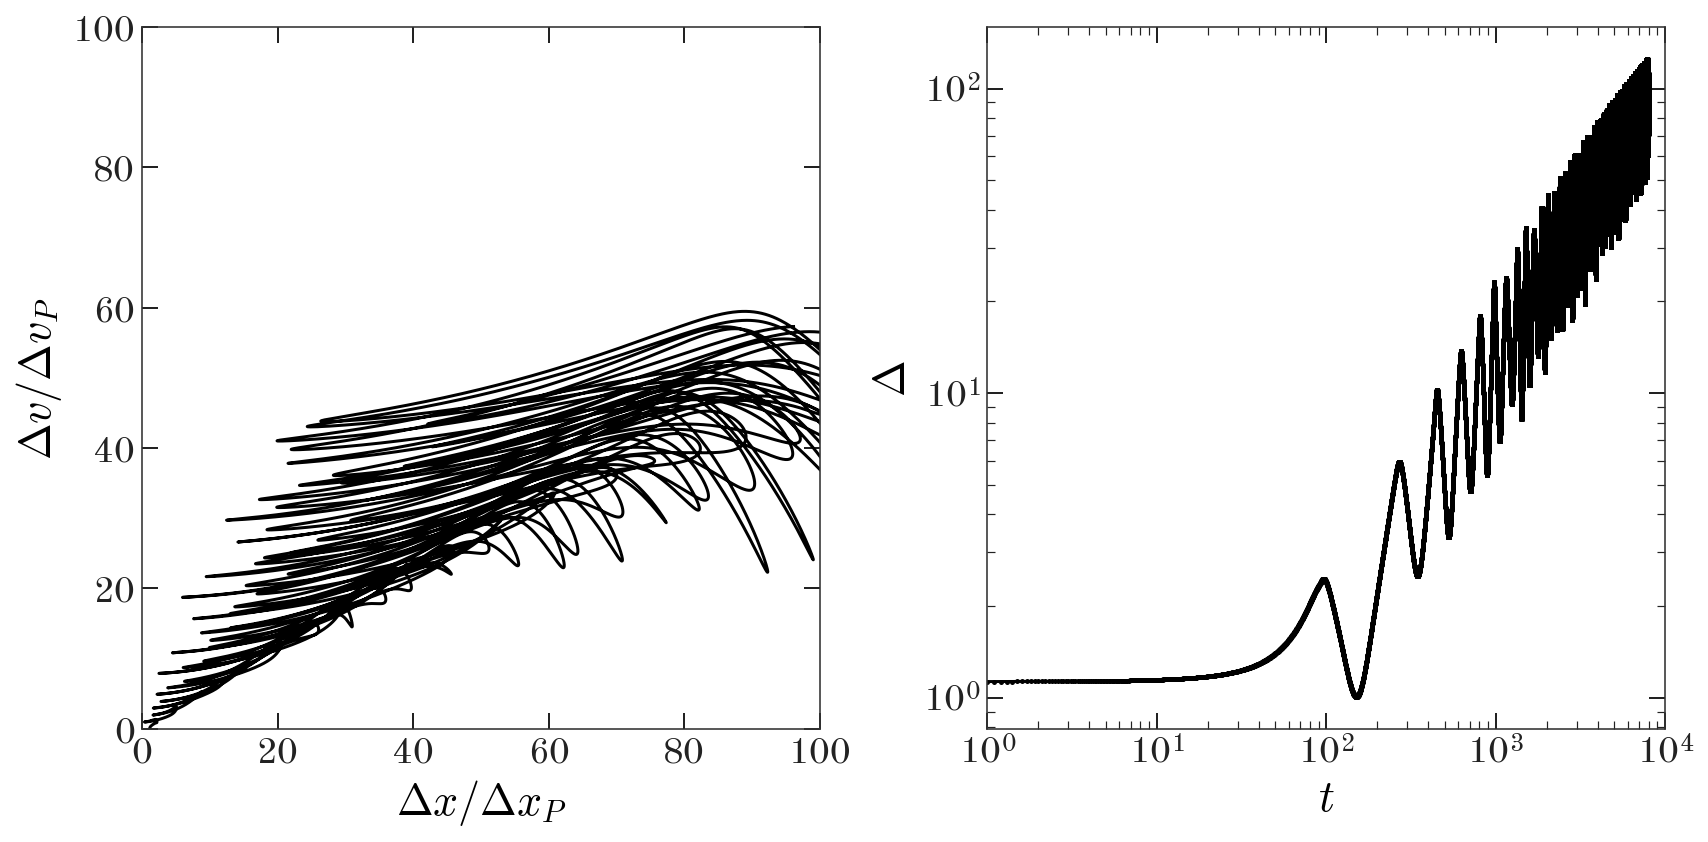

In [203]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
ax.plot(dpos_norm, dvel_norm, marker='')
ax.set_xlabel(r'$\Delta x / \Delta x_P$')
ax.set_ylabel(r'$\Delta v / \Delta v_P$')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

ax = axes[1]
ax.plot(orbits.t.value, np.sqrt(dpos_norm**2 + dvel_norm**2))
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\Delta$')
ax.set_xlim(1, 1e4)
# ax.set_ylim(0, 50)
ax.set_xscale('log')
ax.set_yscale('log')

fig.tight_layout()

---

Now, put pairs (i.e. disrupted binaries) on orbits in a grid and look at the separation at t=8 Gyr or whatever

In [2]:
pot = gp.CCompositePotential()
pot['disk'] = gp.MiyamotoNagaiPotential(
    m=6e10, a=3.5, b=0.28, units=galactic)
pot['halo'] = gp.NFWPotential.from_M200_c(
    M200=1e12*u.Msun, c=15, units=galactic)
pot['halo'] = gp.NFWPotential(
    m=pot['halo'].parameters['m'],
    r_s=pot['halo'].parameters['r_s'],
    b=0.95, c=0.9, units=galactic)

H = gp.Hamiltonian(pot)

### Compute a grid of orbits in x-z plane; vx=vz=0, set vy to keep E constant

In [3]:
from scipy.optimize import root

In [5]:
pot = gp.CCompositePotential()
pot['disk'] = gp.MiyamotoNagaiPotential(
    m=6e10, a=3.5, b=0.28, units=galactic)
pot['halo'] = gp.NFWPotential.from_M200_c(
    M200=1e12*u.Msun, c=15, units=galactic)
pot['halo'] = gp.NFWPotential(
    m=pot['halo'].parameters['m'],
    r_s=pot['halo'].parameters['r_s'],
    b=0.95, c=0.9, units=galactic)

H = gp.Hamiltonian(pot)

In [6]:
x0 = 15. * u.kpc
vy0 = 215 * u.km/u.s
fiducial_w0 = gd.PhaseSpacePosition(
    pos=[1., 0, 0] * x0,
    vel=[0, 1, 0] * vy0)
E0 = H.energy(fiducial_w0)[0].to( (u.km/u.s)**2 )

In [34]:
# _grid = np.arange(0, 30+1e-3, 0.2)
# xgrid, zgrid = map(np.ravel, np.meshgrid(_grid, _grid))

# _xgrid = np.arange(5, 20+1e-3, 0.25)
# _zgrid = np.arange(0, 7.5+1e-3, 0.25)

_xgrid = np.arange(5, 15+1e-3, 0.2)
_zgrid = np.arange(0, 10+1e-3, 0.2)

xgrid, zgrid = map(np.ravel, np.meshgrid(_xgrid, _zgrid)) 

def minfunc(vy, x, z):
    return 0.5*vy**2 + H.potential([x, 0, z]).to_value((u.km/u.s)**2) - E0.value

In [35]:
vygrid = np.full_like(xgrid, np.nan)
for n in trange(len(xgrid)):
    res = root(minfunc, 200., args=(xgrid[n], zgrid[n]))
    if res.success:
        vygrid[n] = res.x

In [36]:
mask = np.isfinite(vygrid)
xs = xgrid[mask]
zs = zgrid[mask]
vys = vygrid[mask]

dxs = np.zeros(mask.sum()) * u.kpc
dvs = np.zeros(mask.sum()) * u.km/u.s
periods = np.zeros(mask.sum()) * u.Gyr

freqs = np.zeros((3, mask.sum(), 2))
for n in trange(mask.sum()):
    w0_1 = gd.PhaseSpacePosition(
        pos=[xs[n], 0, zs[n]] * u.kpc,
        vel=[0, vys[n], 0] * u.km/u.s)
    
    # Typical of binary disruption?
    w0_2 = gd.PhaseSpacePosition(w0_1.xyz + 1 * u.pc,
                                 w0_1.v_xyz + 1e-1 * u.km/u.s)

    w0s = gd.combine((w0_1, w0_2))
    
    # First: to guess orbital period
    orbits = H.integrate_orbit(w0s, dt=0.5*u.Myr, t1=0, t2=8*u.Gyr, 
                               Integrator=gi.DOPRI853Integrator)
    
    dpos = (orbits[:, 0].pos - orbits[:, 1].pos).norm()
    dvel = (orbits[:, 0].vel - orbits[:, 1].vel).norm()
    
    dxs[n] = dpos[-1]
    dvs[n] = dvel[-1]
    periods[n] = orbits[:, 0].estimate_period()

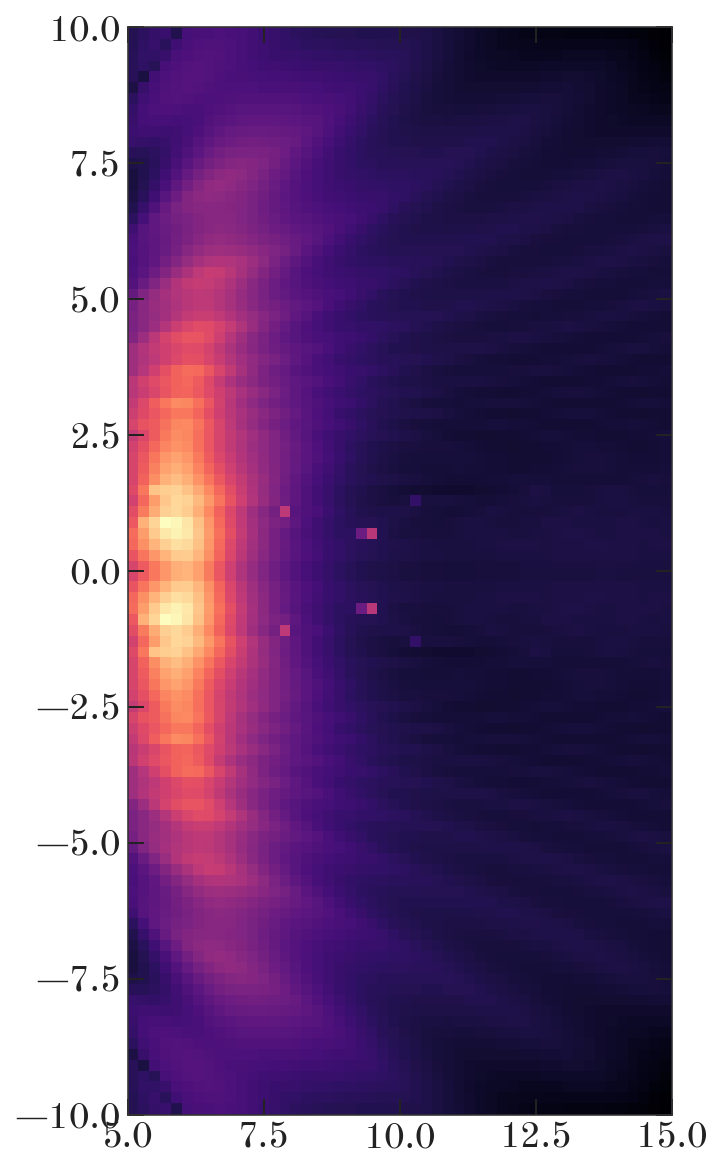

In [48]:
c = dxs.to_value(u.kpc) # / periods.to_value(u.Gyr)
# np.log10(dxs.to_value(u.kpc) / periods.to_value(u.Gyr))
# c = np.log10(dvs.to_value(u.km/u.s))

fig, ax = plt.subplots(figsize=(6, 10))

c = c.reshape((len(_zgrid), len(_xgrid)))
for a in [1, -1]:
    cs = ax.pcolormesh(_xgrid, a * _zgrid, c, 
                        shading='auto')
# plt.xlim(5, 20)
# plt.ylim(-5, 5)

ax.set_aspect('equal')